In [32]:
import gym
import os
import tensorflow as tf
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython import display

In [7]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [15]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### Open AI Gym

In [3]:
env = gym.make('CartPole-v0')

# Run a demo of the environment
obs = env.reset()
img = env.render(mode="rgb_array")
img.shape

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


(400, 600, 3)

In [4]:
env.action_space

Discrete(2)

In [5]:
action = 1
obs, reward, done, info = env.step(action)
print(obs)
print(reward)
print(done)
print(info)

[ 0.03150874  0.20358672 -0.00907854 -0.31793274]
1.0
False
{}


### Simple Basic Policy

In [6]:
def basic_policy(obs):
    angle = obs[2]
    # accelerate left if the pole is leaning left, and vice versa
    return 0 if angle < 0 else 1

In [7]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000): # 1000 steps max
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
#         show_state(env, step, info)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [8]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.122, 8.542547395244583, 24.0, 72.0)

### Neural Network Policy

In [9]:
n_inputs = 4 # == env.observation_space.shape[0]
n_hidden = 4
n_outputs = 1 # probability of acclerating left

learning_rate = 0.01
initializer = tf.contrib.layers.variance_scaling_initializer()

In [10]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
                         kernel_initializer=initializer)
outputs = tf.nn.sigmoid(logits)

# select action out of probabilities [left, right]
p_left_and_right = tf.concat(axis=1, values=[outputs, 1-outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

### REINFORCE Algorithm

In [11]:
y = 1. - tf.to_float(action)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]

gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)

In [12]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std
            for discounted_rewards in all_discounted_rewards]

In [13]:
n_iterations = 250
n_max_steps = 1000
n_games_per_update = 10 # update policy every n episodes
save_iterations = 10
discount_rate = 0.95

In [47]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        all_rewards = [] # all sequences of raw rewards for each episode
        all_gradients = [] # gradients saved at each step of each episode
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients],
                                                    feed_dict = {X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        
        # After playing n episodes, we are ready to update our policy
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean(
                [reward * all_gradients[game_index][step][var_index]
                    for game_index, rewards in enumerate(all_rewards)
                    for step, reward in enumerate(rewards)],
                axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "rl_model/my_policy_net_pg.ckpt")

In [15]:
def pg_policy(sess, obs):
    return sess.run(action, feed_dict={X: obs.reshape(1, n_inputs)})[0][0]

In [17]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "rl_model/my_policy_net_pg.ckpt")
    
    totals = []
    for episode in range(500):
        episode_rewards = 0
        obs = env.reset()
        for step in range(1000): # 1000 steps max
            fitted_action = pg_policy(sess, obs)
            obs, reward, done, info = env.step(fitted_action)
    #         show_state(env, step, info)
            episode_rewards += reward
            if done:
                break
        totals.append(episode_rewards)
    
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))

INFO:tensorflow:Restoring parameters from rl_model/my_policy_net_pg.ckpt
184.298 23.88809737086652 33.0 200.0


### Markov Decision Process

In [18]:
nan = np.nan

In [21]:
T = np.array([ # shape=[s, a, s']
    [[.7, .3, .0], [1., .0, .0], [.8, .2, .0]],
    [[.0, 1., .0], [nan, nan, nan], [.0, .0, 1.]],
    [[nan, nan, nan], [.8, .1, .1], [nan, nan, nan]],
])
R = np.array([ # shape = [s, a, s']
    [[10., .0, .0], [.0, .0, .0], [.0, .0, .0]],
    [[10., .0, .0], [nan, nan, nan], [.0, .0, -50.]],
    [[nan, nan, nan], [40., .0, .0], [nan, nan, nan]],
])

possible_actions = [[0, 1, 2], [0, 2], [1]]

### Q-Value Iteration Algorithm

In [30]:
Q = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    # zero for possible actions, -inf otherwise
    Q[state, actions] = 0.0

learning_rate = .01
discount_rate = .95
n_iterations = 100

for iteration in range(n_iterations):
    Q_prev = Q.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q[s, a] = np.sum([
                T[s, a, sp] * (R[s, a, sp] + discount_rate * np.max(Q_prev[sp]))
                for sp in range(3) # sp is next state transitioned by action a
            ])

In [31]:
print(Q)

# Optimal actions for each state
# It varies when you change discount_rate
print(np.argmax(Q, axis=1))

[[21.88646117 20.79149867 16.854807  ]
 [ 1.10804034        -inf  1.16703135]
 [       -inf 53.8607061         -inf]]
[0 2 1]


### Q-Learning Algorithm (Off-Policy)

In [33]:
learning_rate0 = 0.05
learning_rate_decay = 0.1
n_iterations = 20000

In [34]:
s = 0 # start in state 0

Q = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q[state, actions] = .0

for iteration in range(n_iterations):
    a = rnd.choice(possible_actions[s]) # choose action randomly
    sp = rnd.choice(range(3), p=T[s, a]) # pick next state using T[s, a]
    reward = R[s, a, sp]
    learning_rate = learning_rate0 / (1 + iteration * learning_rate_decay)
    Q[s, a] = learning_rate * Q[s, a] + (1 - learning_rate) * (
        reward + discount_rate * np.max(Q[sp])
    )
    s = sp # move to next state

In [35]:
print(Q)
print(np.argmax(Q, axis=1))

[[132.13378789 125.52709849 125.5270137 ]
 [ 77.93009839         -inf  85.70369039]
 [        -inf 137.70415792         -inf]]
[0 2 1]


## Learning to Play Ms. Pac-Man Using Deep Q-Learning

In [4]:
env = gym.make("MsPacman-v0")
obs = env.reset()
print(obs.shape)


(210, 160, 3)
Discrete(9)


In [5]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

Saving figure preprocessing_plot


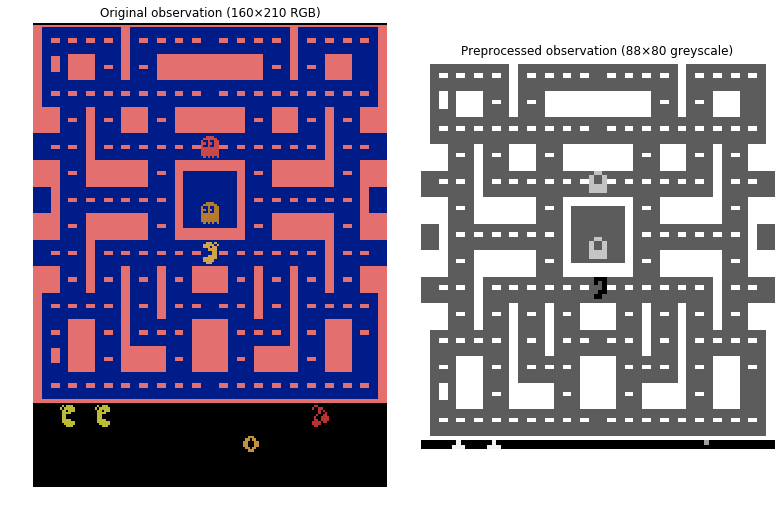

In [17]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

In [18]:
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.contrib.layers.variance_scaling_initializer()

In [19]:
def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [20]:
tf.reset_default_graph()

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [21]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

In [22]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keep_dims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [23]:
from collections import deque

replay_memory_size = 500000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [24]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [25]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

In [26]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [ ]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

Iteration 1830784	Training step 455196/4000000 (11.4)%	Loss 3.304318	Mean Max-Q 40.837618    

In [36]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


In [37]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig,
                                   update_scene,
                                   fargs=(frames, patch),
                                   frames=len(frames),
                                   repeat=repeat,
                                   interval=interval)

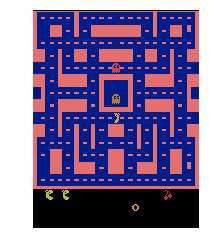

In [38]:
plot_animation(frames)